In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_fscore_support
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


data_file = "./Epileptic Seizure Recognition.csv"
df = pd.read_csv(data_file)
df_original = df.copy()

## **Baseline: stddev + LogisticRegression**

In [ ]:
# This might not be our baseline model. From the data visualization I intuitively think stddev is a good parameter, so I use it as the single feature to do the LogisticRegression
data_std = df.copy()
data_std.drop('Unnamed', axis=1, inplace=True)
class_relabeling = {1:1, 2:0, 3:0, 4:0, 5:0}
data_std.replace({'y': class_relabeling}, inplace=True)

data_std['stddev'] = data_std.iloc[:, :-1].std(axis=1)
data_std['y'] = data_std['y'].apply(lambda x: 1 if x == 1 else 0)

X = data_std[['stddev']]
y = data_std['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.957391304347826
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1835
           1       0.94      0.84      0.89       465

    accuracy                           0.96      2300
   macro avg       0.95      0.91      0.93      2300
weighted avg       0.96      0.96      0.96      2300



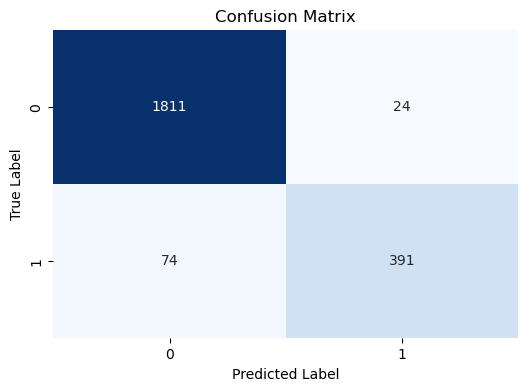

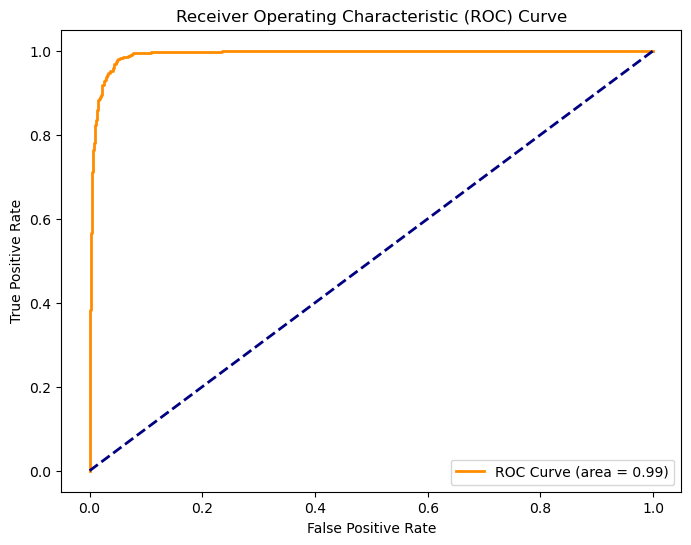

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## **XGBoost**

In [33]:
# Comment
# XGBoost is an ensemble learning method that builds a series of decision trees, where each tree corrects the errors made by the previous ones.
# It's specifically appropriate for this problem due to the nature that this dataset has a large amount of features (~180) with non of each is a dominant feature. (We also verify this nature in the following result by feature importance graph).
# So it's suitable for each tree to correct the errors made by the previous ones, and this can gradually lead to good combined final result.

/Users/apple/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 0.97
Precision: 0.97
Recall: 0.90
F1 Score: 0.93
AUC-ROC Score: 1.00

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1840
           1       0.97      0.90      0.93       460

    accuracy                           0.97      2300
   macro avg       0.97      0.95      0.96      2300
weighted avg       0.97      0.97      0.97      2300



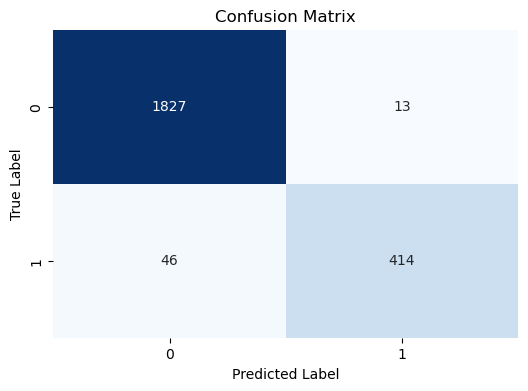

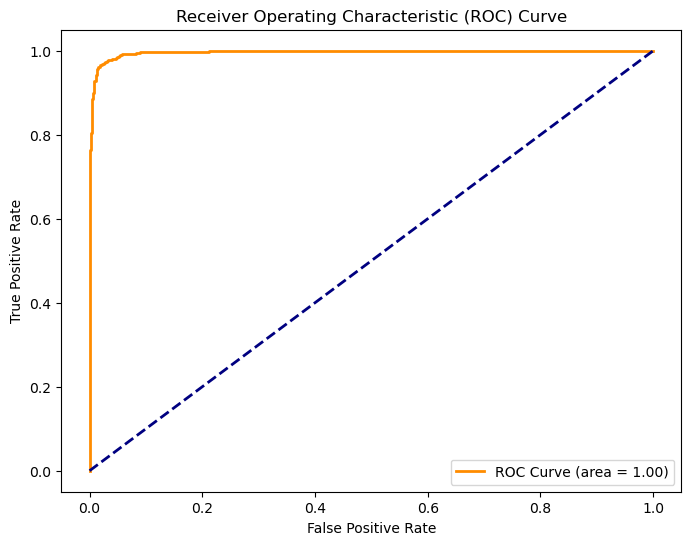

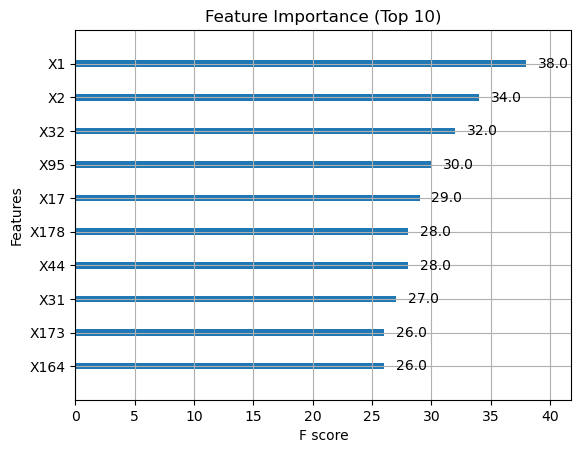

In [ ]:
df_xgb = df.copy()
df_xgb.drop('Unnamed', axis=1, inplace=True, errors='ignore')

# preprocessing
class_relabeling = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0}
df_xgb.replace({'y': class_relabeling}, inplace=True)
X = df_xgb.drop(columns=['y'])
y = df_xgb['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# cross-validation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC-ROC Score: {auc_roc:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title='Feature Importance (Top 10)')
plt.show()


Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/apple/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/apple/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6; total time=   3.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=4, n_estimators=100, subsample=0.6; total time=   3.3s


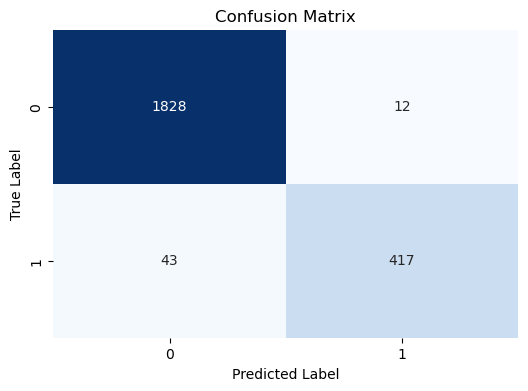

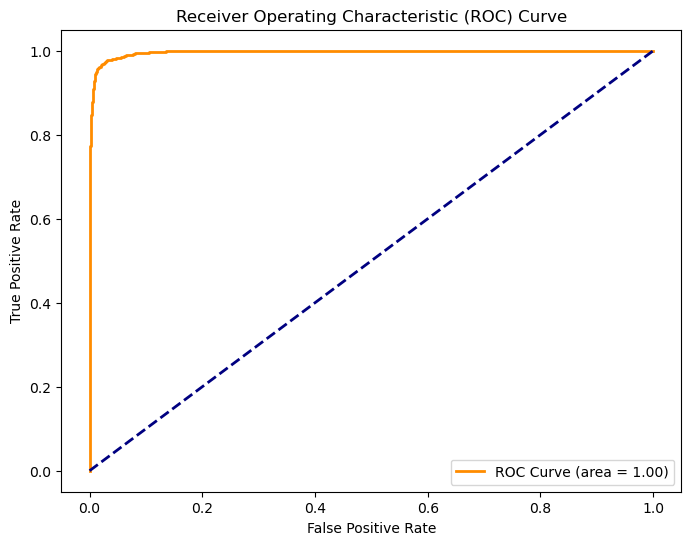

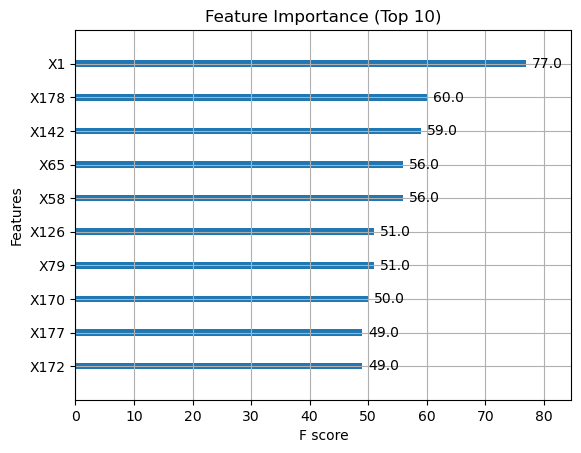

In [ ]:
df_xgb_hyper = df.copy()
df_xgb_hyper.drop('Unnamed', axis=1, inplace=True, errors='ignore')

# preprocessing
class_relabeling = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0}
df_xgb_hyper.replace({'y': class_relabeling}, inplace=True)
X = df_xgb_hyper.drop(columns=['y'])
y = df_xgb_hyper['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# XGBoost model
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# cross-validation & hyper tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

# Predict and evaluation
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC-ROC Score: {auc_roc:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Feature Importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10, title='Feature Importance (Top 10)')
plt.show()


## **Conclusion**

#### Performance metrics improvement:
from stddev_logistic(baseline) -> XGBoost -> XGBoost_hyper_tuning
* Overall acc: 0.96 -> 0.97 -> 0.98
* Recall (class 1): 0.84 -> 0.90 -> 0.91
* F1-score (class 1): 0.89 -> 0.93 -> 0.94
* ROC: 0.99 -> 1.00 -> 1.00

There is an apparent increase in Recall for class 1, which means the model do improve performance a lot. The high ROC score shows that the model is perhaps robust enough.

Moreover, we see from the feature importance graph that there is a relatively small difference among the features (except the first several), suggesting comparable contributions to the model, and this shows that there is no dominant feature. This also implicitly verifies the robustness and advantage of XGBoost.